# Trying Contextual Bandit Algorithms 

Code inspired by the [Pyma bandit library](https://www.di.ens.fr/~cappe/Code/PymaBandits/) by O. Cappé and A. Garivier and the [SMPyBandit library](https://github.com/SMPyBandits/SMPyBandits) of Lilian Besson.

Notebook to be finished and sent by e-mail (together with all the needed file so that I can run your notebook) to emilie.kaufmann@univ-lille.fr by **November 30th, 2020**. Don't hesitate to add comments and interpretation of the experiments.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

# Bandit specific functions and classes (same as last time) 
import Arms as arm
from StochasticBandit import * 
from BanditBaselines import * # you will need UCB alpha into your baselines 

from Experiments import * # all the previous functions to run experiments

# I) Defining a Linear Bandit Environement 

For simplicity, we will first experiment in a setting in which the feature $x_a \in \mathbb{R}^d$ associated to each arm $a$ is fixed in every rounds. That is, the set of arms available in round $t$ is  $$\mathcal X_t = \{x_1,\dots,x_K\} \subseteq \mathbb R^d$$ and it can still be identified with $\{1,\dots,K\}$. 

In this linear bandit model, when arm $A_t \in \{1,\dots,K\}$ is chosen in round $t$, a reward 
$$r_t = x_{A_t}^\top \theta_\star + \varepsilon_t$$
is generated, for some $\theta_\star \in \mathbb R^d$ (unknown to the agent). To generate data, we will further assume that the noise is Gaussian with zero mean and some standard deviation $\sigma^2$. 

The following function creates such a linear bandit model and notably depends on a matrix $X \in \mathbb{R}^{K \times d}$ where each row $a$ of $X$ is $x_a^\top$. 

In [2]:
def LinearBandit(X,theta,sigma):
    """X : matrix of features of dimension (K,d), 
    theta : regression vector of dimension (d,1), 
    sigma : stdev of Gaussian noise"""
    Arms = []
    (K,d)=np.shape(X)
    for k in range(K):
        mu = np.dot(X[k,:],theta)[0]
        arm = arms.Gaussian(mu,sigma)
        Arms.append(arm)
    return MAB(Arms)


**Create a random linear bandit instance of your choice, with normalized features (i.e. $\|x_a\|\leq 1$) and $\|\theta\|=1$.** 

Display the means and the best arm and settle for a "reasonnably interesting" problem with a gap that is not too large between the best and second-best arm. You may wish to save some interesting pairs (X,$\theta$) of features and regression parameters to work on later, for different dimensions / number of arms. 

In [3]:
K=10
d=5 

X = np.random.normal(0,1,(K,d))

for k in range(K):
    X[k,:]=X[k,:]/np.linalg.norm(X[k,:])

theta = np.random.random((d,1))
theta = theta / np.linalg.norm(theta)

sigma=0.5

linear_bandit = LinearBandit(X,theta,sigma)

print("the means are",linear_bandit.means)
print("the best arm is",linear_bandit.bestarm)
print("gaps are",linear_bandit.means[linear_bandit.bestarm]-linear_bandit.means)


# save features and theta if you which to try this bandit problem again
#np.savetxt("X1.csv", X, delimiter=",")
#np.savetxt("theta1.csv", X, delimiter=",")

# load saved features and theta
#X = np.genfromtxt("X0.csv", delimiter=",")
#theta = np.genfromtxt("theta0.csv", delimiter=",")
#linear_bandit = LinearBandit(X,theta,sigma)

the means are [0.3543070716807507, 0.5171602849166356, -0.37667155718318235, 0.6344446673185001, -0.6979627535531212, -0.3148455608363439, 0.8162612745786197, -0.23248529896269085, -0.33399909975199554, 0.2933116870929401]
the best arm is 6
gaps are [0.4619542  0.29910099 1.19293283 0.18181661 1.51422403 1.13110684
 0.         1.04874657 1.15026037 0.52294959]


# II) Implementing least-squares and the greedy strategy

The function below gives the code for the Follow-the-Leader algorithm using least-square estimation to estimate $\theta_\star$ and the mean reward of each arm, i.e. the algorithm selecting in round $t+1$ arm  
$$A_{t+1} = \underset{a \in \{1,\dots,K\}}{\text{argmax}} \ x_a^\top \hat{\theta}_t^{\lambda},$$
where $\hat{\theta}_t^{\lambda}$ is the regularized least-square estimate, with regularization parameter $\lambda$.

**Complete the code with the online least-square update that is needed.**

In [4]:
class Greedy:
    """follow the leader using least-square estimation"""
    def __init__(self,X,reg=1):
        # the algorithms is fed with the known matrix of features (K,d) and the regularization parameter
        self.features = X
        (self.nbArms,self.dimension) = np.shape(X)
        self.reg = reg
        self.clear()

    def clear(self):
        # initialize the design matrix, its inverse, 
        # the vector containing the sum of r_s*x_s and the least squares estimate
        self.Design = self.reg*np.eye(self.dimension)
        self.DesignInv = (1/self.reg)*np.eye(self.dimension)
        self.Vector = np.zeros((self.dimension,1))
        self.thetaLS = np.zeros((self.dimension,1)) # regularized least-squares estimate
    
    def chooseArmToPlay(self):
        # compute the vector of estimated means  
        muhat = np.dot(self.features,self.thetaLS)
        # select the arm with largest estimated mean 
        return randmax(muhat)


    def receiveReward(self,arm,reward):
        x = self.features[arm,:].reshape((self.dimension,1))
        self.Design = self.Design + np.dot(x,np.transpose(x)) 
        self.Vector = self.Vector + reward*x
        # online update of the inverse of the design matrix
        Y = np.dot(self.DesignInv,x)
        self.DesignInv = self.DesignInv - (1/(1 + np.dot(np.transpose(x),Y)))*np.dot(Y,np.transpose(Y)) 
        # update of the least squares estimate 
        self.thetaLS = np.dot(self.DesignInv,self.Vector)

    def name(self):
        return "greedyLB"

**Experiment with the greedy strategy on one run. Is it finding the best arm?** 

You may also compare the least square estimate at the end of the algorithm with the true parameter $\theta_\star$.

Keep in mind that things can vary a lot between two different runs, don't hesitate to try multiple times.

In [5]:
T = 1000
strategy1 = Greedy(X)

selections,rewards = OneBanditOneLearnerOneRun(linear_bandit, strategy1, T)
print(selections,"\n")

print("the least square estimate is",np.transpose(theta))
print("the true parameter is ",np.transpose(strategy1.thetaLS),"\n")
print("estimates of the means are",np.transpose(np.dot(X,strategy1.thetaLS)))   
print("the true means are",linear_bandit.means)

[8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

The linear bandit model that we created is a particular instance of a multi-armed bandit model in which each arm is Gaussian with variance $\sigma^2$. Therefore, we can also apply a standard UCB algorithm for this problem (that will not leverage the fact that all the means depend on the same regression parameter). With a well-chosen parameter for the UCB, this algorithm is guaranteed to have logarithmic regret on any linear bandit model (but the regret may be smaller for an algorithm leveraging the linear structure).

**Compare the regret (estimated over multiple runs) of the greedy algorithm implemented above with that of a UCB algorithm and that of the FTL algorithm implemented last time (i.e. the greedy algorithm that does *not* use the linear structure).**


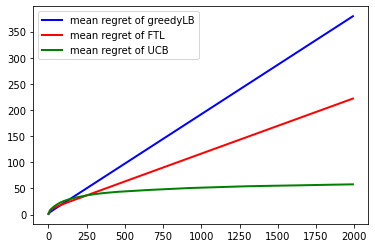

In [6]:
alpha=2*sigma**2

strategy1 = Greedy(X)
strategy2 = FTL(K)
strategy3 = UCB(K,alpha)

RunExpes([strategy1, strategy2,strategy3],linear_bandit,200,2000,10,"off")

The regret of UCB is logarithmic, while both greedy algorithms have a linear regret, with the features not really helping...  

# III) Smarter algorithms

Implement the following algorithms: 
* LinUCB taking as an input a threshold function $\beta(t,\delta)$: 
$$A_{t+1}^{\text{LinUCB}} = \underset{a \in \{1,\dots,K\}}{\text{argmax}} \left[x_a^\top \hat{\theta}_t^{\lambda} + \beta(t,\delta) ||x_a||_{\left(B_t^{\lambda}\right)^{-1}}\right]$$
* Thompson Sampling, taking as an input a posterior inflation parameter $v$ 
$$A_{t+1}^{\text{LinTS}} = \underset{a \in \{1,\dots,K\}}{\text{argmax}} \ x_a^\top \tilde{\theta}_t$$
where $\tilde{\theta}_t$ is a sample from $\mathcal{N}\left(\hat{\theta}_t^{\lambda}, v^2 \left(B_t^{\lambda}\right)^{-1}\right)$.

Compare their regret with that of the same UCB algorithm that before, which is guaranteed to have logarithmic regret but does not make use of the features. 


In [7]:
class LinUCB:
    """LinUCB strategy"""
    def __init__(self,X,beta=0,delta=0.05,reg=1):
        # the algorithms is fed with the known matrix of features (K,d), a threshold function beta(t,delta) and the regularization parameter
        self.features = X
        (self.nbArms,self.dimension) = np.shape(X)
        self.reg = reg 
        self.beta = beta
        if (beta ==0):
            # default stylized threshold choice: \sqrt{2log(1/delta) + dlog(t)}
            self.beta = (lambda t,u : np.sqrt(2*log(1/u) + self.dimension*np.log(t)))
        self.delta = delta
        self.clear()

    def clear(self):
        # initialize the design matrix, its inverse, the vector containing the sum of r_s*x_s and the least squares estimate
        self.Design = self.reg*np.eye(self.dimension)
        self.DesignInv = (1/self.reg)*np.eye(self.dimension)
        self.Vector = np.zeros((self.dimension,1))
        self.thetaLS = np.zeros((self.dimension,1))
        self.t = 1
    
    def chooseArmToPlay(self):
        means = np.dot(self.features,self.thetaLS)
        indices = np.zeros(self.nbArms)
        for a in range(self.nbArms):
            x = self.features[a,:].reshape((self.dimension,1))
            indices[a] = means[a] + np.sqrt(np.dot(np.transpose(x),np.dot(self.DesignInv,x)))*self.beta(self.t,self.delta)
        return randmax(indices)

    def receiveReward(self,arm,reward):
        x = self.features[arm,:].reshape((self.dimension,1))
        self.Design = self.Design + np.dot(x,np.transpose(x)) 
        self.Vector = self.Vector + reward*x
        # online update of the inverse of the design matrix
        Y = np.dot(self.DesignInv,x)
        self.DesignInv = self.DesignInv - (1/(1 + np.dot(np.transpose(x),Y)))*np.dot(Y,np.transpose(Y)) 
        # update of the least squares estimate 
        self.thetaLS = np.dot(self.DesignInv,self.Vector)
        self.t = self.t + 1

    def name(self):
        return "LinUCB"

Let's see how LinUCB performs on one run. 

In [8]:
T = 2000

# specify a threshold
beta = lambda t,delta : sigma*np.sqrt(2*log(1/delta) + d*log(t))
strategy = LinUCB(X,beta,0.05,1)

start = time.time()
selections,rewards = OneBanditOneLearnerOneRun(linear_bandit, strategy, T)
print("elapsed time is",time.time()-start)
print(selections,"\n")

print("the least square estimate is",np.transpose(theta))
print("the true parameter is ",np.transpose(strategy1.thetaLS),"\n")

elapsed time is 0.31594300270080566
[9, 1, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 9, 0, 6, 6, 6, 6, 6, 9, 1, 6, 6, 6, 9, 6, 3, 1, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 9, 9, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 9, 9, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 9, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [9]:
class LinTS:
    """Linear Thompson Sampling strategy"""
    def __init__(self,X,v=1,reg=1):
        # the algorithms is fed with the known matrix of features (K,d), v posterior inflation parameter
        self.features = X
        (self.nbArms,self.dimension) = np.shape(X)
        self.reg = reg 
        self.v = v 
        self.clear()

    def clear(self):
        # initialize the design matrix, its inverse, the vector containing the sum of r_s*x_s and the least squares estimate
        self.Design = self.reg*np.eye(self.dimension)
        self.DesignInv = (1/self.reg)*np.eye(self.dimension)
        self.Vector = np.zeros((self.dimension,1))
        self.thetaLS = np.zeros((self.dimension,1))
        self.t = 1
    
    def chooseArmToPlay(self):
        thetaTilde = np.random.multivariate_normal(self.thetaLS.reshape(self.dimension,), (self.v*self.v)*self.DesignInv)
        indices=np.dot(self.features,thetaTilde)
        return randmax(indices)

    def receiveReward(self,arm,reward):
        x = self.features[arm,:].reshape((self.dimension,1))
        self.Design = self.Design + np.dot(x,np.transpose(x)) 
        self.Vector = self.Vector + reward*x
        # online update of the inverse of the design matrix
        Y = np.dot(self.DesignInv,x)
        self.DesignInv = self.DesignInv - (1/(1 + np.dot(np.transpose(x),Y)))*np.dot(Y,np.transpose(Y)) 
        # update of the least squares estimate 
        self.thetaLS = np.dot(self.DesignInv,self.Vector)
        self.t = self.t + 1

    def name(self):
        return "LinTS"

and now Thompson Sampling. 

In [10]:
T = 2000

# specify a threshold
strategy = LinTS(X,sigma)

start = time.time()
selections,rewards = OneBanditOneLearnerOneRun(linear_bandit, strategy, T)
print("elapsed time is",time.time()-start)
print(selections,"\n")

print("the least square estimate is",np.transpose(theta))
print("the true parameter is ",np.transpose(strategy1.thetaLS),"\n")

elapsed time is 0.32634687423706055
[1, 0, 0, 1, 3, 0, 5, 6, 3, 0, 2, 6, 6, 9, 1, 6, 6, 6, 9, 9, 6, 9, 6, 1, 1, 9, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 1, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 

In class, we mentioned possible choices for the threshold function $\beta(t,\delta)$ for which LinUCB is guaranteed to have sub-linear regret, as well as a choice of the parameter $v$ for which LinTS has sub-linear regret. But one can also tune these parameter a little bit. In particular for LinTS, the parameter $v=\sigma$ would correspond to the true Bayesian Thompson Sampling algorithm (i.e. it uses the exact posterior distribution using the fact that the noise is Gaussian with variance $\sigma^2$). 

**Compare the regret of UCB with that of two versions of LinUCB (one with the theoretical threshold, the other with a heuristic threshold) and two versions of Thompson Sampling (theoretical and heuristic parameter $v$).** 

Comment the results obtained. 

In [11]:
# initializing the algorithms

T = 5000

UCBalgo = UCB(K,2*sigma**2)

beta = lambda t,delta : sigma*np.sqrt(2*log(1/delta) + d*log(1+t/d)) + 1
LinUCB_Theory = LinUCB(X,beta,1/T,1)

betaHeuristic = lambda t,delta : sigma*np.sqrt(log(t))
LinUCB_Heuristic = LinUCB(X,betaHeuristic,0.05,1)

v = sigma*sqrt(9*d*log(T/0.05))
LinTS_Theory = LinTS(X,v)
LinTS_Heuristic = LinTS(X,sigma)

algorithms = [UCBalgo,LinUCB_Theory,LinUCB_Heuristic,LinTS_Theory,LinTS_Heuristic]
names = ["UCB","LinUCB theory","LinUCB heuristic","LinTS theory","LinTS heuristic"]

In [12]:
# launching the experiments and gathering data (takes time!) 

Nexp = 100
tsave = np.arange(1,T,20)

start = time.time()
RegretUCB = OneBanditOneLearnerMultipleRuns(linear_bandit, UCBalgo, T, Nexp, tsave)
print("time elapsed for",Nexp,"runs of UCB:",time.time()-start) 

start = time.time()
RegretLinUCBT = OneBanditOneLearnerMultipleRuns(linear_bandit, LinUCB_Theory, T, Nexp, tsave)
print("time elapsed for",Nexp,"runs of LinUCB - theory:",time.time()-start)   

start = time.time()
RegretLinUCB = OneBanditOneLearnerMultipleRuns(linear_bandit, LinUCB_Heuristic, T, Nexp, tsave)
print("time elapsed for",Nexp,"runs of LinUCB - heuristic:",time.time()-start)

start = time.time()
RegretLinTST = OneBanditOneLearnerMultipleRuns(linear_bandit, LinTS_Theory, T, Nexp, tsave)
print("time elapsed for",Nexp,"runs of LinTS - theory:",time.time()-start)

start = time.time()
RegretLinTS = OneBanditOneLearnerMultipleRuns(linear_bandit, LinTS_Heuristic, T, Nexp, tsave)
print("time elapsed for",Nexp,"runs of LinTS - heuristic:",time.time()-start)

time elapsed for 100 runs of UCB: 11.921751499176025
time elapsed for 100 runs of LinUCB - theory: 76.11287260055542
time elapsed for 100 runs of LinUCB - heuristic: 69.47322750091553
time elapsed for 100 runs of LinTS - theory: 75.51624584197998
time elapsed for 100 runs of LinTS - heuristic: 75.92685174942017


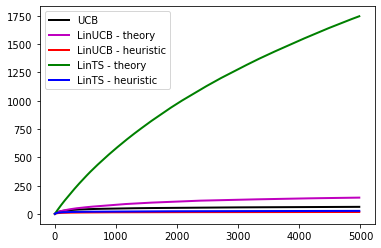

In [13]:
# Plot the regret for the 5 algorithms. 

colors = ["b","r","g","k","m"]
plt.clf()

plt.plot(tsave, np.mean(RegretUCB, 0), linewidth=2.0, color="k", label="UCB")
plt.plot(tsave, np.mean(RegretLinUCBT, 0), linewidth=2.0, color="m", label="LinUCB - theory")
plt.plot(tsave, np.mean(RegretLinUCB, 0), linewidth=2.0, color="r", label="LinUCB - heuristic")
plt.plot(tsave, np.mean(RegretLinTST, 0), linewidth=2.0, color="g", label="LinTS - theory")
plt.plot(tsave, np.mean(RegretLinTS, 0), linewidth=2.0, color="b", label="LinTS - heuristic")

plt.legend()
plt.show()

LinTS with posterior inflation performed very bad, let's see what happens without this algorithm on the plots. 

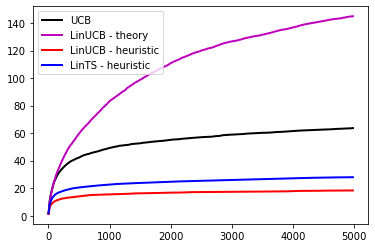

In [14]:
colors = ["b","r","g","k","m"]
plt.clf()

plt.plot(tsave, np.mean(RegretUCB, 0), linewidth=2.0, color="k", label="UCB")
plt.plot(tsave, np.mean(RegretLinUCBT, 0), linewidth=2.0, color="m", label="LinUCB - theory")
plt.plot(tsave, np.mean(RegretLinUCB, 0), linewidth=2.0, color="r", label="LinUCB - heuristic")
#plt.plot(tsave, np.mean(RegretLinTST, 0), linewidth=2.0, color="g", label="LinTS - theory")
plt.plot(tsave, np.mean(RegretLinTS, 0), linewidth=2.0, color="b", label="LinTS - heuristic")

plt.legend()
plt.show()

LinUCB with a heuristic threshold and LinTS with $v = \sigma$ can exploit the features and beat UCB. 